In [1]:
import numpy as np

Device: cuda
Training PINN for 2D linear elasticity (plane stress)...
Epoch     0/2000 | Loss=5.783972e-01 | Res_u=3.593e-02 | Res_v=1.983e-02
Epoch   200/2000 | Loss=1.911254e-04 | Res_u=8.327e-05 | Res_v=8.063e-05
Epoch   400/2000 | Loss=5.349857e-05 | Res_u=1.380e-05 | Res_v=3.816e-05
Epoch   600/2000 | Loss=2.785095e-05 | Res_u=7.070e-06 | Res_v=2.017e-05
Epoch   800/2000 | Loss=1.565983e-05 | Res_u=4.667e-06 | Res_v=1.054e-05
Epoch  1000/2000 | Loss=9.123684e-06 | Res_u=3.154e-06 | Res_v=5.580e-06
Epoch  1200/2000 | Loss=5.497247e-06 | Res_u=2.151e-06 | Res_v=2.991e-06
Epoch  1400/2000 | Loss=3.418404e-06 | Res_u=1.485e-06 | Res_v=1.607e-06
Epoch  1600/2000 | Loss=2.206913e-06 | Res_u=1.048e-06 | Res_v=8.601e-07
Epoch  1800/2000 | Loss=1.502404e-06 | Res_u=7.644e-07 | Res_v=4.628e-07
Epoch  1999/2000 | Loss=1.098256e-06 | Res_u=5.852e-07 | Res_v=2.575e-07
Training completed in 322.08s


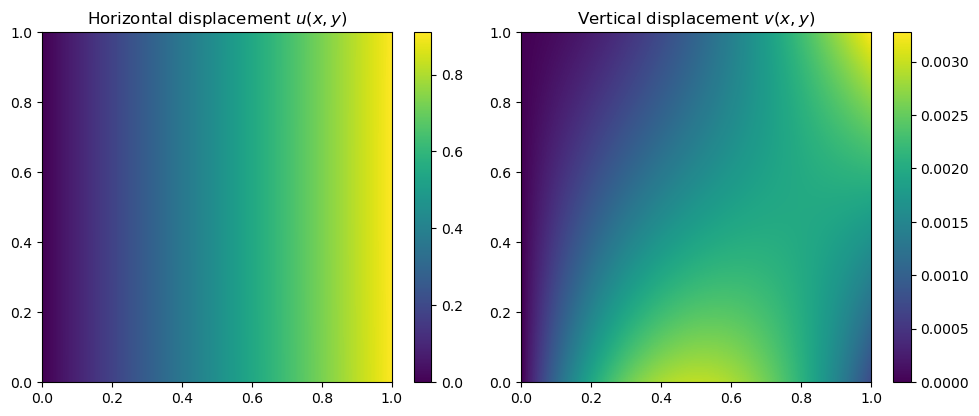

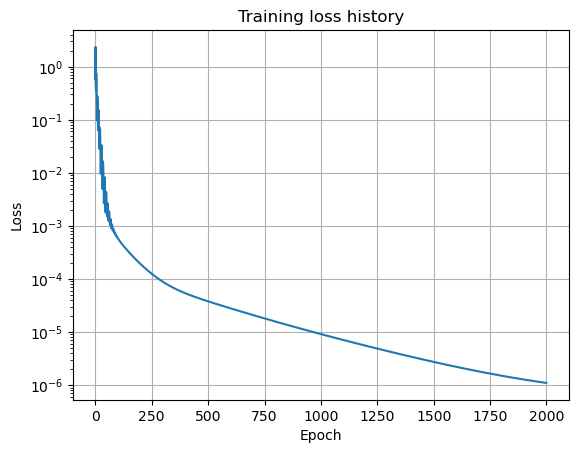

In [2]:
#%% -----------------------------------------------------------
# 2D Linear Elasticity PINN (Plane Stress)
# Boundary: u=v=0 at x=0, traction T at x=1
# Geometry: 1m x 1m square
#---------------------------------------------------------------

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time, random, os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# ---------------- GPU / seed ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
manualSeed = 1234
torch.manual_seed(manualSeed); np.random.seed(manualSeed); random.seed(manualSeed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(manualSeed)

#%% ---------------- Neural network ----------------
class Net2D(nn.Module):
    """
    Fully connected neural network for 2D elasticity displacement field.

    Parameters
    ----------
    n_input : int
        Number of input features (x, y).
    n_output : int
        Number of output features (u, v).
    n_layer : int
        Number of hidden layers.
    n_nodes : int
        Number of neurons per hidden layer.
    """
    def __init__(self, n_input=2, n_output=2, n_layer=8, n_nodes=80):
        super().__init__()
        self.input = nn.Linear(n_input, n_nodes)
        self.hidden = nn.ModuleList([nn.Linear(n_nodes, n_nodes) for _ in range(n_layer)])
        self.output = nn.Linear(n_nodes, n_output)
        for L in [self.input, self.output] + list(self.hidden):
            nn.init.xavier_uniform_(L.weight)
            nn.init.normal_(L.bias, std=1e-3)
        self.act = torch.tanh

    def forward(self, x):
        y = self.act(self.input(x))
        for L in self.hidden:
            y = self.act(L(y))
        return self.output(y)  # -> [u, v]

#%% ---------------- Domain setup ----------------
nelx, nely = 150, 150  # grid resolution
xs = np.linspace(0.0, 1.0, nelx+1)
ys = np.linspace(0.0, 1.0, nely+1)
X, Y = np.meshgrid(xs, ys)
pts = np.hstack([X.reshape(-1,1, order='F'), Y.reshape(-1,1, order='F')])
N_total = pts.shape[0]
data = torch.tensor(pts, dtype=torch.float32, device=device, requires_grad=True)

# Right edge indices (x = 1)
tol = 1e-6
right_idx = np.where(np.abs(pts[:,0] - 1.0) < tol)[0]
right_idx_t = torch.tensor(right_idx, dtype=torch.long, device=device)

#%% ---------------- Material & load ----------------
E = 1.0         # Young's modulus
nu = 0.3        # Poisson's ratio
T = 1.0         # Traction on right edge

#%% ---------------- Model and boundary handling ----------------
net_uv = Net2D().to(device)

def uv_tilde(pt):
    """
    Impose homogeneous Dirichlet BC (u=v=0) at x=0 via multiplicative mask.
    """
    xcoord = pt[:,0:1]
    out = net_uv(pt)
    return xcoord * out  # ensures u=v=0 at x=0

#%% ---------------- Linear elasticity residual ----------------
def elasticidad_lineal2d(E=1.0, nu=0.3, T=1.0):
    """
    Compute the PDE-based loss for 2D linear elasticity (plane stress).

    Parameters
    ----------
    E : float
        Young's modulus.
    nu : float
        Poisson's ratio.
    T : float
        Applied traction on the right boundary.

    Returns
    -------
    loss : torch.Tensor
        Total loss (PDE + BC).
    res_u : torch.Tensor
        Mean squared PDE residual in x-direction.
    res_v : torch.Tensor
        Mean squared PDE residual in y-direction.
    """
    uv = uv_tilde(data)
    u, v = uv[:, 0:1], uv[:, 1:2]

    # First derivatives
    du = torch.autograd.grad(u, data, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    dv = torch.autograd.grad(v, data, torch.ones_like(v), retain_graph=True, create_graph=True)[0]
    du_x, du_y = du[:, 0:1], du[:, 1:2]
    dv_x, dv_y = dv[:, 0:1], dv[:, 1:2]

    # Strain tensor components
    exx = du_x
    eyy = dv_y
    exy = 0.5 * (du_y + dv_x)

    # Lame parameters (plane stress)
    lam = (E * nu) / (1 - nu**2)
    mu = E / (2 * (1 + nu))

    # Stress components
    sxx = lam * (exx + eyy) + 2 * mu * exx
    syy = lam * (exx + eyy) + 2 * mu * eyy
    sxy = 2 * mu * exy

    # Divergence of stress tensor
    dsxx_dx = torch.autograd.grad(sxx, data, torch.ones_like(sxx), retain_graph=True, create_graph=True)[0][:, 0:1]
    dsxy_dy = torch.autograd.grad(sxy, data, torch.ones_like(sxy), retain_graph=True, create_graph=True)[0][:, 1:2]
    dsyy_dy = torch.autograd.grad(syy, data, torch.ones_like(syy), retain_graph=True, create_graph=True)[0][:, 1:2]
    dsxy_dx = torch.autograd.grad(sxy, data, torch.ones_like(sxy), retain_graph=True, create_graph=True)[0][:, 0:1]

    # PDE equilibrium residuals
    res_u = dsxx_dx + dsxy_dy  # ∂σxx/∂x + ∂σxy/∂y = 0
    res_v = dsyy_dy + dsxy_dx  # ∂σyy/∂y + ∂σxy/∂x = 0
    loss_pde = torch.mean(res_u**2 + res_v**2)

    # Traction BC at right edge (σxx = T, σxy = 0)
    sxx_right = sxx[right_idx_t]
    sxy_right = sxy[right_idx_t]
    loss_bc = torch.mean((sxx_right - T)**2 + sxy_right**2)

    # Total loss
    loss = loss_pde + loss_bc
    return loss, torch.mean(res_u**2), torch.mean(res_v**2)

#%% ---------------- Training ----------------
epochs = 2000
lr = 1e-3
optimizer = torch.optim.Adam(net_uv.parameters(), lr=lr)
loss_history = []

print("Training PINN for 2D linear elasticity (plane stress)...")
start = time.time()

for ep in range(epochs):
    optimizer.zero_grad()
    loss, res_u, res_v = elasticidad_lineal2d(E=E, nu=nu, T=T)
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if ep % 200 == 0 or ep == epochs-1:
        print(f"Epoch {ep:5d}/{epochs} | Loss={loss.item():.6e} | Res_u={res_u.item():.3e} | Res_v={res_v.item():.3e}")

print(f"Training completed in {(time.time()-start):.2f}s")

#%% ---------------- Visualization ----------------
uv_pred = uv_tilde(data).detach().cpu().numpy()
u_pred = uv_pred[:,0].reshape(nely+1, nelx+1, order='F')
v_pred = uv_pred[:,1].reshape(nely+1, nelx+1, order='F')

fig, axs = plt.subplots(1,2,figsize=(10,4))
im0 = axs[0].imshow(u_pred, extent=[0,1,0,1], origin='lower', cmap='viridis')
axs[0].set_title("Horizontal displacement $u(x,y)$")
plt.colorbar(im0, ax=axs[0])
im1 = axs[1].imshow(v_pred, extent=[0,1,0,1], origin='lower', cmap='viridis')
axs[1].set_title("Vertical displacement $v(x,y)$")
plt.colorbar(im1, ax=axs[1])
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss history")
plt.grid(True)
plt.show()
